In [1]:
import numpy as np
import jax.numpy as jnp
import pandas as pd
import matplotlib.pyplot as plt

from functools import partial
import jax
from jax import grad, jit, lax, random, vmap
import jax.scipy as scipy

In [2]:
import evofr as ef

In [3]:
WILDTYPE_COLOR = "green"
VARIANT_COLOR = "purple"
GRAY = "gray"
ORANGE = "darkorange" 

In [4]:
# Get coords
# Coordinates, transmission pairs, and whether mutation was one branch
wt_coords = [(-360,0),  
    (-180, 100),  (-0, 100),
    (180, 150), (180, 50),
    (360, 200), (360, 100)]
wt_pairs = [(1,2), (2,3), (3,4), (3, 5), (4, 6), (4,7)]
wt_mut = [False, False, False, False, True, False]

# Coordinates, transmission pairs, and whether mutation was one branch
var_coords = [(-180, -100),  
    (-0, -150), (-0, -50), 
    (180, 0), (180, -200), (180, -150), (180, -100),
    (360, -215), (360, -185), (360, -150), (360, -115), (360, -85), (360, -25), (360, 25)]
var_pairs = [(1,2), (1,3), (2,5), (2,6), (2,7), 
    (3,4), (4,13), (4,14), (5,8), (5,9),
    (6,10), (7,11), (7, 12)]
var_mut = [False, False, False, False, False,
    True, False, False, False, False, 
    True, False, False]

In [5]:
def unpack_segments(coords, pairs):
    y = [np.column_stack([coords[x-1], coords[y-1]]).T for x,y in pairs]
    return y * np.array([1.0, -1.0])

def unpack_mutations(segments, mut):
    mut_locs = [seg.mean(axis=0) for v, seg in enumerate(segments) if mut[v]]
    x = [m[0] for m in mut_locs]
    y = [m[1] for m in mut_locs]
    return x,y

[]

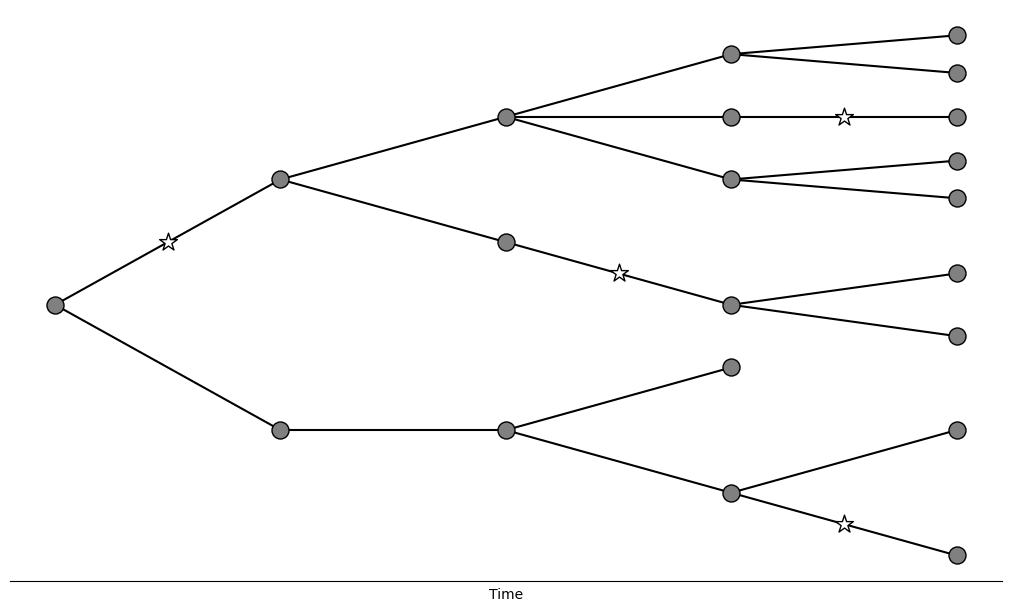

In [6]:
from matplotlib.collections import LineCollection

fig = plt.figure(figsize=(10., 6.), constrained_layout=True)
spec = fig.add_gridspec(ncols=1, nrows=1)

def draw_tree(ax, color_tips = True):
    # Create line segments
    var_segments = unpack_segments(var_coords, var_pairs)
    wt_segments = unpack_segments(wt_coords, wt_pairs)
    connect_groups = unpack_segments([wt_coords[0], var_coords[0]], [(1,2)])

    ax.add_collection(LineCollection(var_segments, linestyles='solid', color="k"))
    ax.add_collection(LineCollection(wt_segments, linestyles='solid', color="k"))
    ax.add_collection(LineCollection(connect_groups, linestyles='solid', color="k"))


    # Plot tips
    ax.scatter([p[0] for p in wt_coords], [-p[1] for p in wt_coords], 
               ec="k", 
               color=WILDTYPE_COLOR if color_tips else GRAY, 
               s=150, 
               zorder=2)
    
    ax.scatter([p[0] for p in var_coords], [-p[1] for p in var_coords], 
               ec="k", 
               color=VARIANT_COLOR if color_tips else GRAY,
               s=150,
               zorder=2)
    
    # Plot mutations
    var_mut_x, var_mut_y = unpack_mutations(var_segments, var_mut)
    ax.scatter(var_mut_x, var_mut_y, marker="*", color="w", ec="k", s=180, zorder=2)

    wt_mut_x, wt_mut_y = unpack_mutations(wt_segments, wt_mut)
    ax.scatter(wt_mut_x, wt_mut_y, marker="*",  color="w", ec="k", s=180, zorder=2)
    
    connect_mut_x, connect_mut_y = unpack_mutations(connect_groups, [True])
    ax.scatter(connect_mut_x, connect_mut_y, marker="*",  color="w", ec="k", s=180, zorder=2)

    
ax = fig.add_subplot(spec[0, 0])
draw_tree(ax, color_tips=False)

# Clean up figure
ax.spines.left.set_visible(False)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_xlabel("Time")
ax.set_xticks([])
ax.set_yticks([])

Text(0.5, 0, 'Number of offspring')

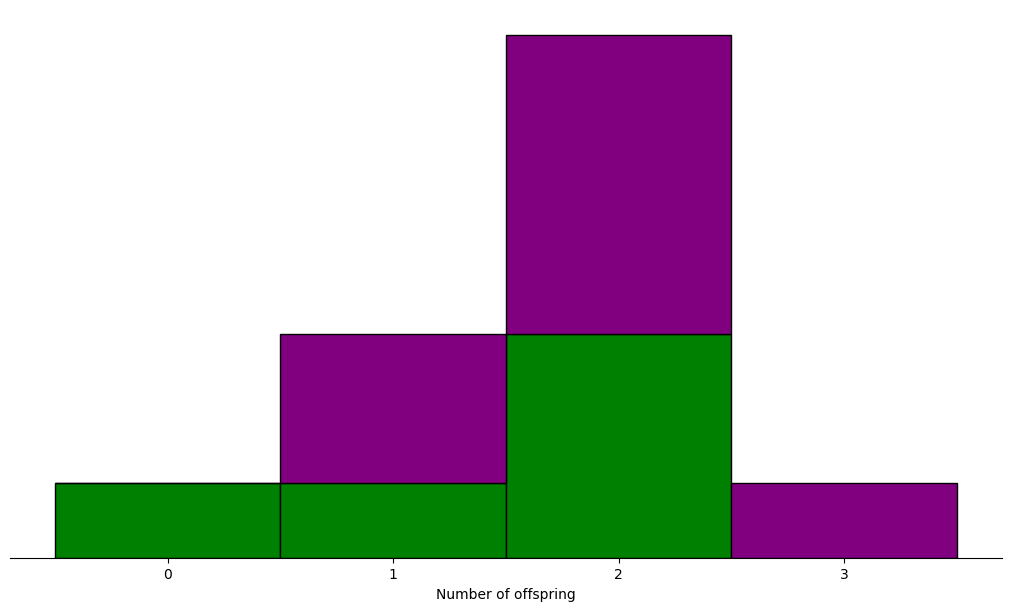

In [7]:
# Number of descendents: Greyed 
from collections import defaultdict

def compute_descendents(pairs, prefix=None):
    if prefix is None:
        prefix = ""
    counts = defaultdict(lambda : 0)
    for parent, child in pairs:
        counts[parent] += 1
    return counts 

def make_descendent_histogram(ax, color_tips=True):
    wt_counts = compute_descendents(wt_pairs)
    wt_counts[1] += 1 # Account for generation of variant
    wt_counts[20] = 0 
    var_counts = compute_descendents(var_pairs)
    
    if color_tips:
        values = [list(wt_counts.values()), list(var_counts.values())]
        ax.hist(values, 
                color=[WILDTYPE_COLOR, VARIANT_COLOR] if color_tips else [GRAY, GRAY], 
                stacked=True,
                ec="k",
                density=True,
                bins=np.arange(0, 3.0 + 1.5) - 0.5)
    else:
        ax.hist(list(wt_counts.values()) + list(var_counts.values()), 
                color= GRAY, 
                ec="k",
                density=True,
                align="mid",
                bins=np.arange(0, 3.0 + 1.5) - 0.5)
    

fig = plt.figure(figsize=(10., 6.), constrained_layout=True)
spec = fig.add_gridspec(ncols=1, nrows=1)

ax = fig.add_subplot(spec[0, 0])
make_descendent_histogram(ax, color_tips=True)

# Clean up figure
ax.spines.left.set_visible(False)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_yticks([])
ax.set_xticks(np.arange(0, 3 + 1))


ax.set_xlabel("Number of offspring")

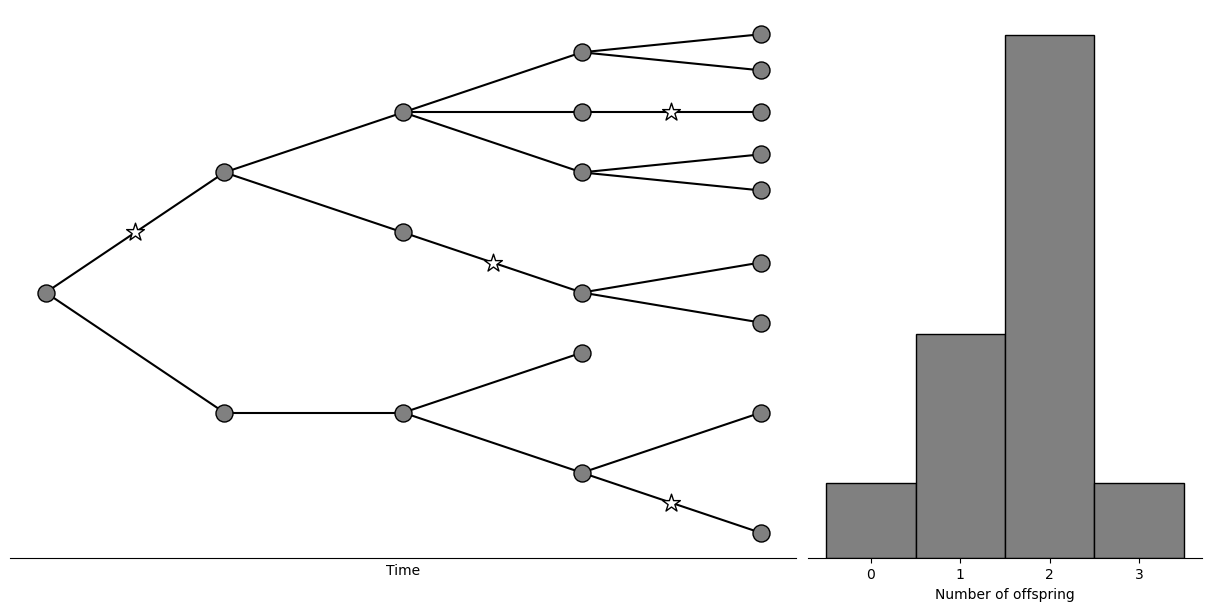

In [8]:
fig = plt.figure(figsize=(12., 6.), constrained_layout=True)
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[1.0, 0.5])

# Add tree
ax_tree = fig.add_subplot(spec[0, 0])
draw_tree(ax_tree, color_tips=False)

# Clean up figure
ax_tree.spines.left.set_visible(False)
ax_tree.spines.right.set_visible(False)
ax_tree.spines.top.set_visible(False)
ax_tree.set_xlabel("Time")
ax_tree.set_xticks([])
ax_tree.set_yticks([])

# Add offspring histogram
ax_hist = fig.add_subplot(spec[0, 1])
make_descendent_histogram(ax_hist, color_tips=False)

# Clean up figure
ax_hist.spines.left.set_visible(False)
ax_hist.spines.right.set_visible(False)
ax_hist.spines.top.set_visible(False)
ax_hist.set_yticks([])
ax_hist.set_xticks(np.arange(0, 3 + 1))
ax_hist.set_xlabel("Number of offspring")

fig.savefig("figures/transmission_tree_offspring_gray.svg", format="svg")

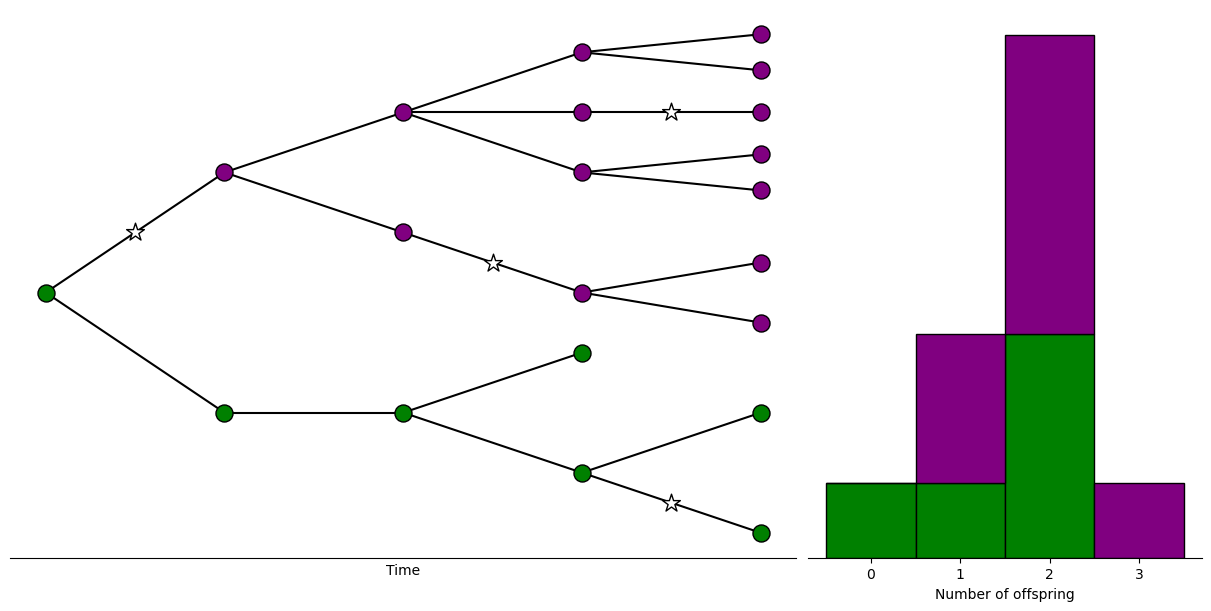

In [9]:
fig = plt.figure(figsize=(12., 6.), constrained_layout=True)
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[1.0, 0.5])

# Add tree
ax_tree = fig.add_subplot(spec[0, 0])
draw_tree(ax_tree, color_tips=True)

# Clean up figure
ax_tree.spines.left.set_visible(False)
ax_tree.spines.right.set_visible(False)
ax_tree.spines.top.set_visible(False)
ax_tree.set_xlabel("Time")
ax_tree.set_xticks([])
ax_tree.set_yticks([])

# Add offspring histogram
ax_hist = fig.add_subplot(spec[0, 1])
make_descendent_histogram(ax_hist, color_tips=True)

# Clean up figure
ax_hist.spines.left.set_visible(False)
ax_hist.spines.right.set_visible(False)
ax_hist.spines.top.set_visible(False)
ax_hist.set_yticks([])
ax_hist.set_xticks(np.arange(0, 3 + 1))
ax_hist.set_xlabel("Number of offspring")

fig.savefig("figures/transmission_tree_offspring_colored.svg", format="svg")

# Simulating and plotting epidemics


In [10]:
SEED = 11 * 2 * 2021
key = random.PRNGKey(SEED)
key, subkey = random.split(key)

In [11]:
from jax.experimental.ode import odeint

@jit
def SIR_step(u, t, θ):
    # Susceptible, Infectious wild type, Infectious variant, Recovered wild type, Recovered variant
    S, I_wt, I_v, R_wt, R_v, Inc_wt, Inc_v =  (u[0], u[1], u[2], u[3], u[4], u[5], u[6])

    # Transmissibility, recovery rate
    # eta_T is added variant transmissibility in susceptibles, 
    # eta_E is escape in recovered wt hosts
    # eta_gam is the ratio between recovery rates
    beta_wt, gam_wt, eta_T, eta_E, eta_gam  = (θ[0], θ[1], θ[2], θ[3], θ[4])
    
    lam_wt = beta_wt * S * I_wt # Wild-type transmission in naive
    lam_vs = (beta_wt * eta_T) * S * I_v # Variant transmission in naive
    lam_vr = (beta_wt * eta_T) * (eta_E * R_wt) * I_v # Variant transmission in wt recovered
    
    recov_wt = gam_wt * I_wt
    recov_v = gam_wt * eta_gam * I_v
    
    # Defining differential equations
    dS = -lam_wt - lam_vs
    dI_wt = lam_wt - recov_wt
    dI_v = lam_vs + lam_vr - recov_v
    dR_wt = recov_wt - lam_vr
    dR_v = recov_v
    
    # New compartments for capturing cummulative incidence
    dIncidence_wt = lam_wt
    dIncidence_v = lam_vs + lam_vr
    
    return jnp.stack([dS, dI_wt, dI_v, dR_wt, dR_v, dIncidence_wt, dIncidence_v])

# Defining model parameters
R0_wt = 1.4 # Basic reproduction number in wild type
R0_v = 1.4 # Basic reproduction number in variant

gen_wt = 3.8 # Average length of infection (days): 1 / gam_wt
gen_v = 3.8 # (...):  1 / gam_v
eta_E = 0.7 # Escape fraction

# Rest of quantities can be computed from the above
gam_wt =  1 / gen_wt
beta_wt = R0_wt * gam_wt

gam_v = 1 / gen_v
beta_v = R0_v * gam_v

eta_gam = gam_v / gam_wt
eta_T = beta_v / beta_wt

In [12]:
#  Defining parameters and initial conditions
true_θ = (beta_wt, gam_wt, eta_T, eta_E, eta_gam)

# Simulate in two parts
## Initial dynamics without variant
u0 = jnp.array([0.999, 0.001, 0.0, 0.0, 0.0, 0.0, 0.0])
t0 = jnp.arange(80.)
Y0 = odeint(SIR_step, u0, t0, true_θ)

## Adding in second variant
u1 = Y0[-1,:] + jnp.array([0.0, 0.0, 1e-4, 0.0, 0.0, 0.0, 0.0])
t1 = jnp.arange(120.)
Y1 = odeint(SIR_step, u1 , t1, true_θ)

# Combining
t = jnp.hstack([t0[:-1], t0[-1] + t1])
Y = jnp.vstack([Y0[:-1,:], Y1])

In [13]:
# Simulating fake data based on cummulative incidence

def simulate_incidence(key, N_pop, Y):
    key1, key2, key3 = random.split(key, 3)
    
    EInc_wt = jnp.clip(jnp.diff(N_pop * Y[:, -2], prepend=0.), a_min = 0.0)
    EInc_v = jnp.clip(jnp.diff(N_pop * Y[:, -1], prepend=0.), a_min = 0.0)
    
    T =  len(EInc_wt)

    Inc_wt = random.poisson(key1, EInc_wt, shape= (T,))
    Inc_v = random.poisson(key2, EInc_v, shape= (T,))
    return key3, Inc_wt, Inc_v

N_pop = 50_000
key, Inc_wt, Inc_v = simulate_incidence(key, N_pop, Y)

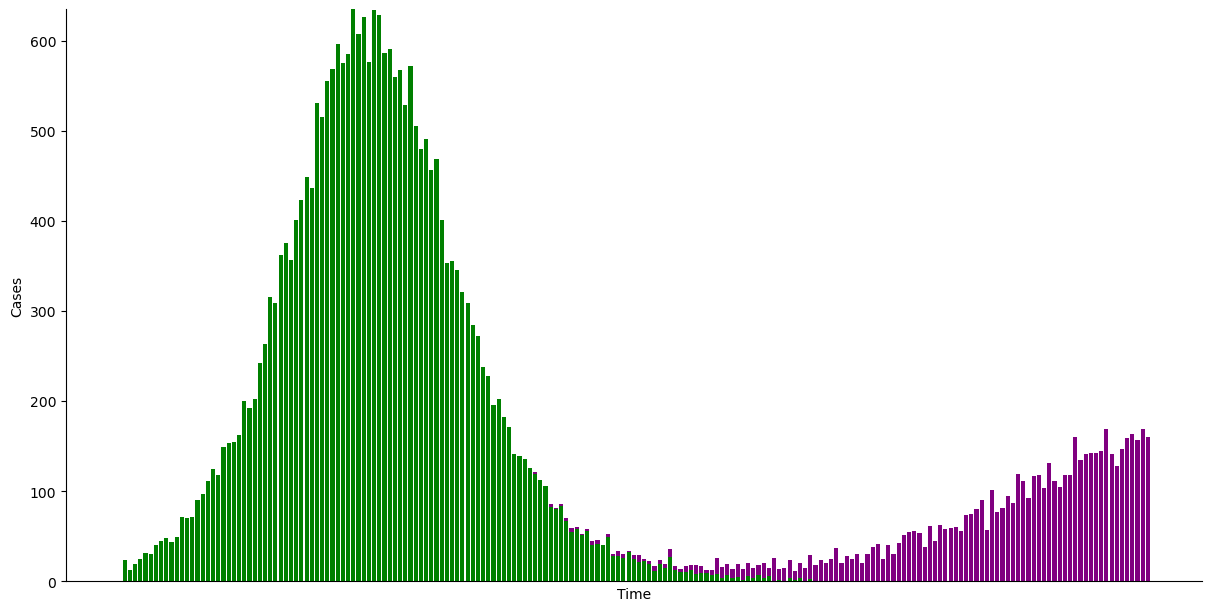

In [52]:
fig = plt.figure(figsize=(12., 6.), constrained_layout=True)
spec = fig.add_gridspec(ncols=1, nrows=1)

ax = fig.add_subplot(spec[0, 0])

# Plotting observed incidence
ax.bar(t, Inc_wt, label = "Wildtype", color = WILDTYPE_COLOR)
ax.bar(t, Inc_v, label = "Immune Escaping Variant", color = VARIANT_COLOR, bottom=Inc_wt)

ax.set_xlabel("Time")
ax.set_ylabel("Cases")

# Clean up axes
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_xticks([])

fig.savefig("figures/variant_cases.svg", format="svg")

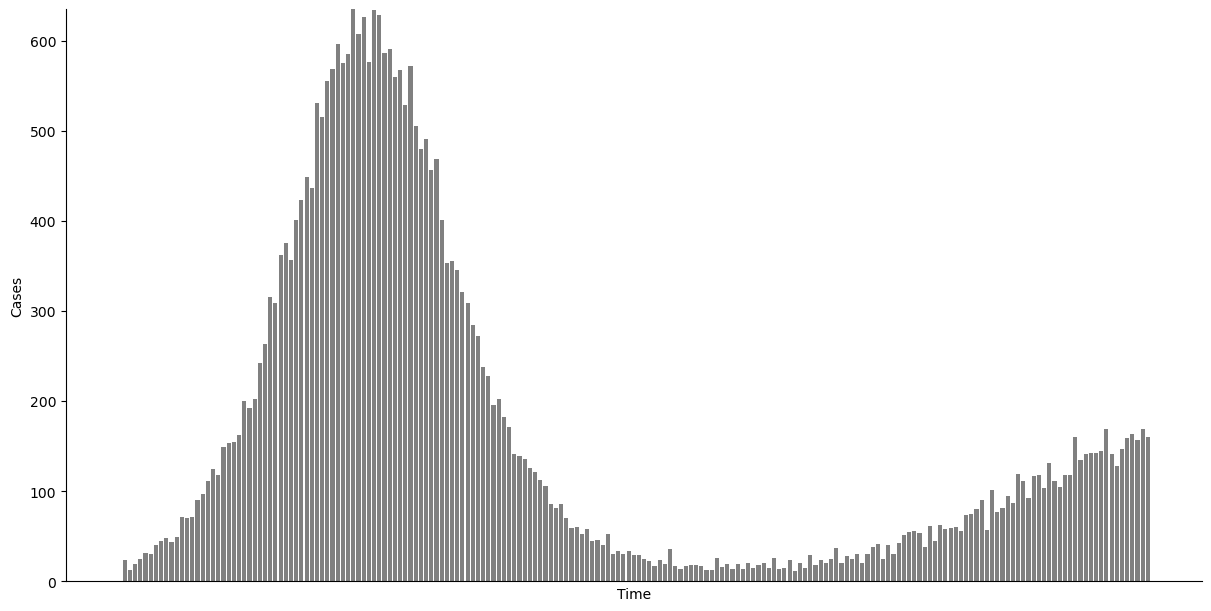

In [15]:
fig = plt.figure(figsize=(12., 6.), constrained_layout=True)
spec = fig.add_gridspec(ncols=1, nrows=1)

ax = fig.add_subplot(spec[0, 0])

# Plotting observed incidence
ax.bar(t, Inc_wt, label = "Wildtype", color = GRAY)
ax.bar(t, Inc_v, label = "Immune Escaping Variant", color = GRAY, bottom=Inc_wt)

ax.set_xlabel("Time")
ax.set_ylabel("Cases")

# Clean up axes
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_xticks([])

fig.savefig("figures/raw_cases.svg", format="svg")

In [16]:
## Getting frequency dynamics
def simulate_sequencing(key, Nsamples, Y):
    key1, key2 = random.split(key, 2)
        
    frac_v = jnp.divide(Y[:, 1][:,None], (Y[:,1] + Y[:,2])[:,None])
    T = len(frac_v)
    samples = random.bernoulli(key, p=frac_v, shape= (T, Nsamples)).sum(axis=1)
    return key, samples

N_samples = 40
key, samples = simulate_sequencing(key, N_samples, Y)

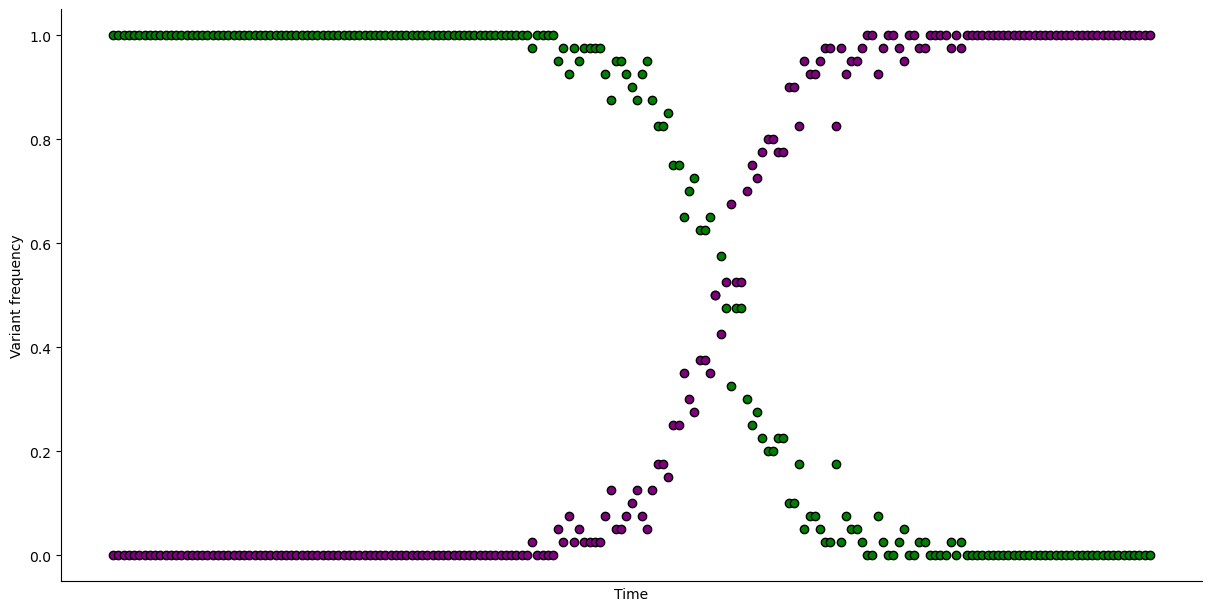

In [51]:
fig = plt.figure(figsize=(12., 6.), constrained_layout=True)
spec = fig.add_gridspec(ncols=1, nrows=1)

ax = fig.add_subplot(spec[0, 0])

# Plotting observed incidence
#ax.bar(t, N_samples - samples, label = "Immune Escaping Variant", color = VARIANT_COLOR)
#ax.bar(t, samples, label = "Wildtype", color = WILDTYPE_COLOR, bottom=N_samples - samples)

# Try scatter plot
ax.scatter(t, samples / N_samples, label = "Wildtype", color = WILDTYPE_COLOR, ec="k")
ax.scatter(t, 1 - samples / N_samples, label = "Immune Escaping Variant", color = VARIANT_COLOR, ec="k")


ax.set_xlabel("Time")
ax.set_ylabel("Variant frequency")

# Clean up axes
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_xticks([])

# Figure out which style to use here?

fig.savefig("figures/raw_frequency.svg", format="svg")

# Do inference and get growth advantage

In [18]:
BASE_DATE = "01-01-2020"

def to_pandas(samples, incidence):
    # Samples to raw_seq    
    T = samples.shape[0]
    dates = [pd.to_datetime(BASE_DATE) + pd.Timedelta(days=d) for d in np.arange(T)]
    
    raw_seq = pd.DataFrame()
    raw_seq["sequences"] = np.concatenate((samples, N_samples-samples))
    raw_seq["variant"] = ["Wildtype"] * T + ["Variant"] * T
    raw_seq["date"] = dates * 2
    raw_seq["location"] = "Synthetic"
    
    # Convert to cases
    T = incidence.shape[0]
    dates = [pd.to_datetime(BASE_DATE) + pd.Timedelta(days=d) for d in np.arange(T)]
    raw_cases = pd.DataFrame()
    raw_cases["cases"] = incidence
    raw_cases["date"] = dates
    raw_cases["location"] = "Synthetic"

    return raw_seq, raw_cases

raw_seq, raw_cases = to_pandas(samples, Inc_wt + Inc_v)

In [19]:
raw_cases

,cases,date,location
0,0,2020-01-01,Synthetic
1,24,2020-01-02,Synthetic
2,13,2020-01-03,Synthetic
3,19,2020-01-04,Synthetic
4,25,2020-01-05,Synthetic
...,...,...,...
194,159,2020-07-13,Synthetic
195,164,2020-07-14,Synthetic
196,157,2020-07-15,Synthetic
197,169,2020-07-16,Synthetic


In [20]:
# Doing inference with evofr

# Defining data object
_raw_seq = raw_seq[raw_seq.date > pd.to_datetime("2020-03-01")].copy()
variant_frequencies = ef.VariantFrequencies(_raw_seq)
case_frequencies = ef.CaseFrequencyData(raw_cases=raw_cases, raw_seq=raw_seq)

In [21]:
# Defining model object
mlr = ef.MultinomialLogisticRegression(gen_wt)
renewal = ef.RenewalModel(ef.discretise_gamma(mn=gen_wt, std=gen_wt),
                          ef.pad_delays([ef.discretise_lognorm(mn=3.1, std=1.0)]),
                          14,
                          0,
                          RLik = ef.GARW(1e-3, 1e-3, prior_family="Normal"),
                          CLik = ef.ZINegBinomCases(0.05),
                          SLik = ef.MultinomialSeq(),
                         latent=False)


In [22]:
# Let's do SVI first
inference_method = ef.InferFullRank(iters=30_000, lr=4e-4, num_samples=1000)

In [23]:
mlr_post = inference_method.fit(mlr, variant_frequencies)

In [24]:
renewal_post = inference_method.fit(renewal, case_frequencies)

In [25]:
ps = [0.95, 0.8, 0.5]
alphas = [0.2, 0.4, 0.6]


v_colors = [WILDTYPE_COLOR, VARIANT_COLOR]

v_names = ["Wildtype", "Variant"]
color_map = {v : c for c, v in zip(v_colors, v_names)}

In [26]:
import matplotlib
import matplotlib.transforms as mtransforms
from evofr.plotting import *

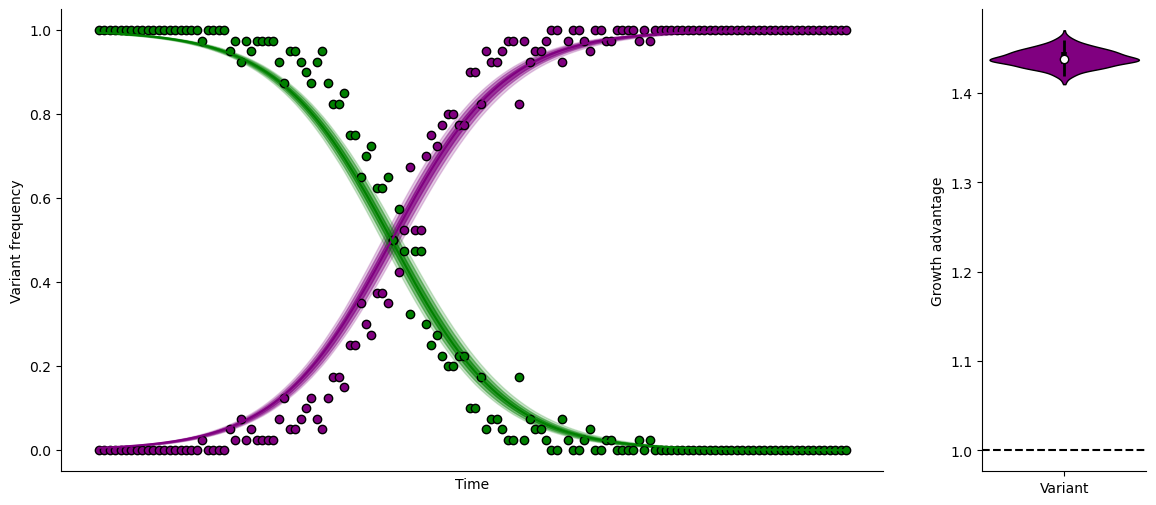

In [38]:
# Plot MLR resutls
fig = plt.figure(figsize=(14, 6))
gs = fig.add_gridspec(nrows=1, ncols=2, width_ratios=[5, 1])

colors = [color_map[v] for v in variant_frequencies.var_names] # Mapping colors to observed variants

# Plot predicted frequencies
ax = fig.add_subplot(gs[0,0])
plot_posterior_frequency(ax, mlr_post.samples, ps, alphas, colors)
#plot_ppc_frequency(ax, posterior.samples, posterior.data, ps, alphas, colors)

plot_observed_frequency(ax, variant_frequencies, colors) # Plot observed frequencies
add_dates_sep(ax, ef.data.expand_dates(variant_frequencies.dates, 0), sep=20) # Adding dates
ax.set_ylabel("Variant frequency") # Making ylabel
ax.set_xlabel("Time")

# Clean up axes
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_xticks([])

ax = fig.add_subplot(gs[0,1])
plot_growth_advantage(ax, mlr_post.samples, variant_frequencies, ps, alphas, colors)

# Clean up axes
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_ylabel("Growth advantage") # Making ylabel


fig.savefig("figures/posterior_mlr_frequency.svg", format="svg")

[]

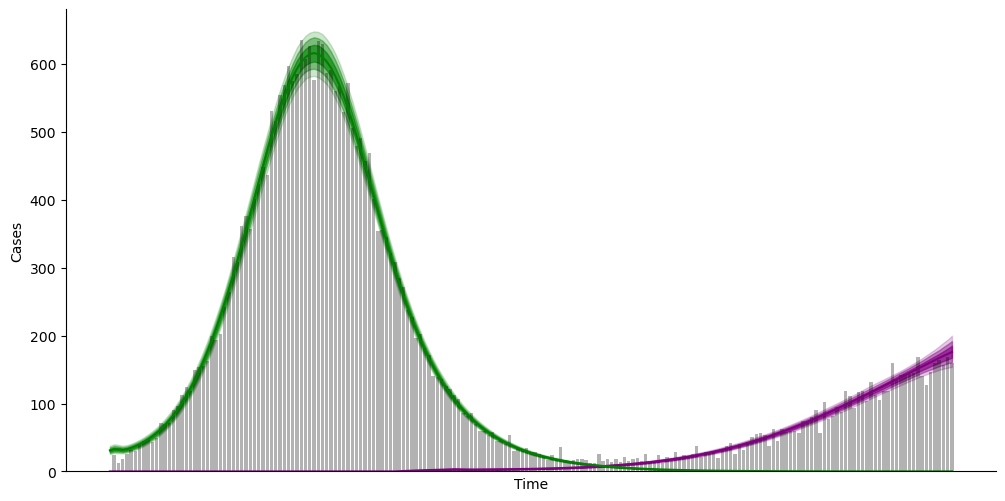

In [28]:
fig = plt.figure(figsize=(12, 6))
gs = fig.add_gridspec(nrows=1, ncols=1)

colors = [color_map[v] for v in case_frequencies.var_names] # Mapping colors to observed variants

# Plot variant specific indicidence
ax = fig.add_subplot(gs[0,0])
plot_posterior_I(ax, renewal_post.samples, ps, alphas, colors)
plot_cases(ax, case_frequencies)
ax.set_ylabel("Cases") # Making ylabel
ax.set_xlabel("Time")

# Clean up axes
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_xticks([])

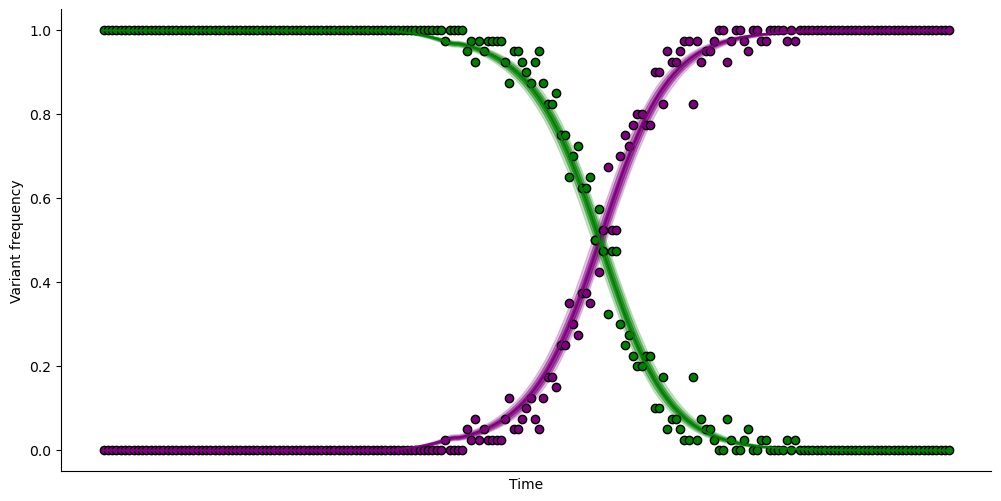

In [109]:
fig = plt.figure(figsize=(12, 6))
gs = fig.add_gridspec(nrows=1, ncols=1)

colors = [color_map[v] for v in case_frequencies.var_names] # Mapping colors to observed variants

# Plot predicted frequencies
ax = fig.add_subplot(gs[0,0])
plot_posterior_frequency(ax, renewal_post.samples, ps, alphas, colors)
#plot_ppc_frequency(ax, posterior.samples, posterior.data, ps, alphas, colors)

plot_observed_frequency(ax, case_frequencies, colors) # Plot observed frequencies
add_dates_sep(ax, ef.data.expand_dates(case_frequencies.dates, 0), sep=20) # Adding dates
ax.set_ylabel("Variant frequency") # Making ylabel
ax.set_xlabel("Time")

# Clean up axes
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_xticks([])

fig.savefig("figures/posterior_renewal_frequency.svg", format="svg")

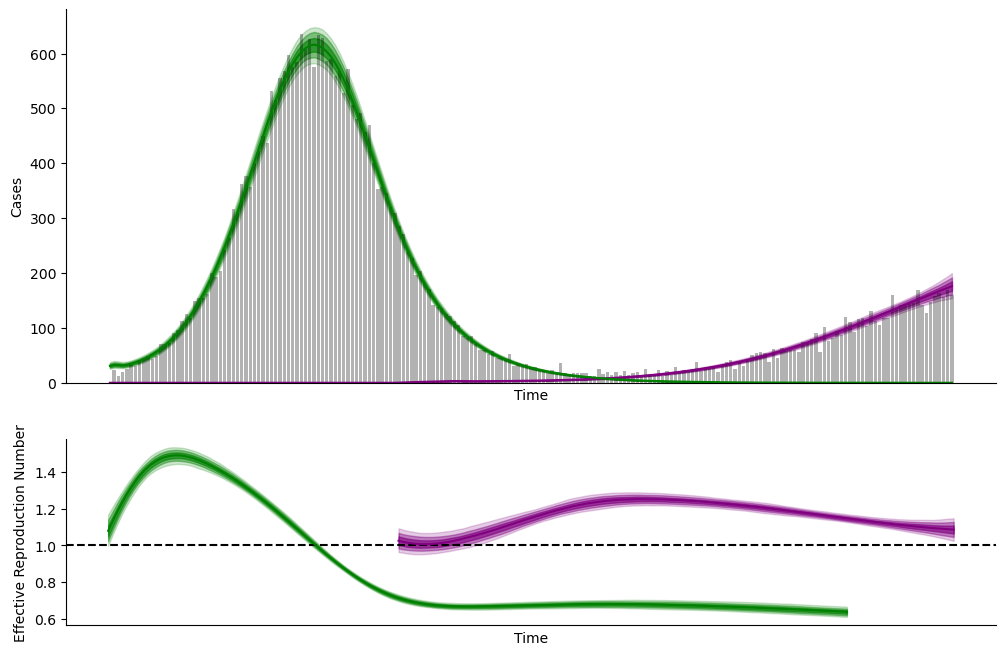

In [49]:
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(nrows=2, ncols=1, height_ratios=[2., 1.])

colors = [color_map[v] for v in case_frequencies.var_names] # Mapping colors to observed variants

# Plot variant specific indicidence
ax = fig.add_subplot(gs[0,0])
plot_posterior_I(ax, renewal_post.samples, ps, alphas, colors)
plot_cases(ax, case_frequencies)
ax.set_ylabel("Cases") # Making ylabel
ax.set_xlabel("Time")

# Clean up axes
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_xticks([])

colors = [color_map[v] for v in case_frequencies.var_names] # Mapping colors to observed variants

# Plot variant specific indicidence
ax = fig.add_subplot(gs[1,0])
plot_R_censored(ax, renewal_post.samples, ps, alphas, colors)
ax.set_ylabel("Effective Reproduction Number") # Making ylabel
ax.set_xlabel("Time")

# Clean up axes
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_xticks([])
fig.savefig("figures/posterior_variants_Rt.svg", format="svg")

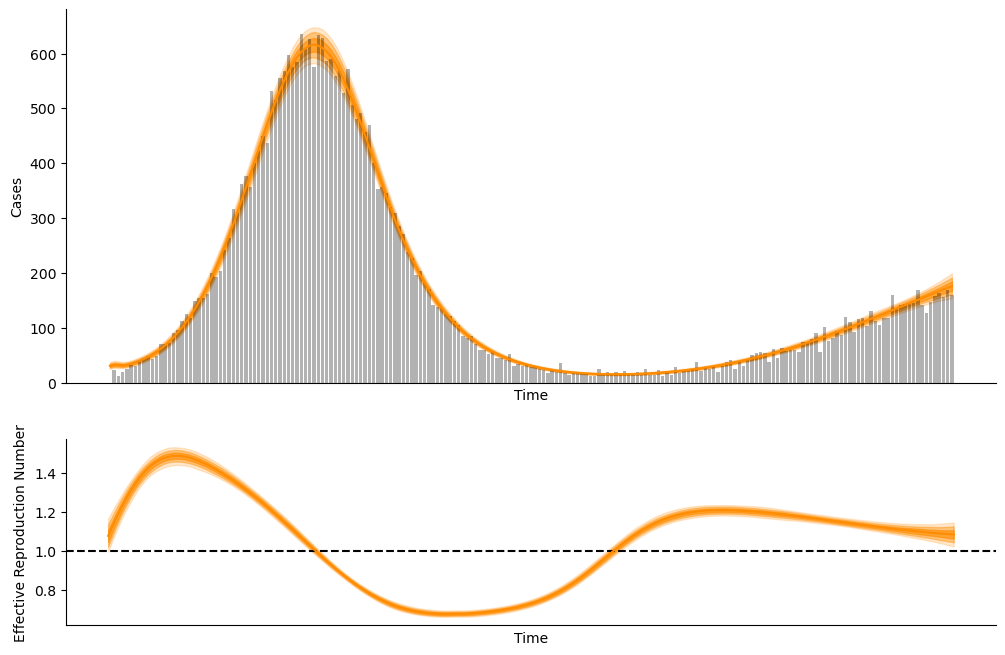

In [106]:
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(nrows=2, ncols=1, height_ratios=[2., 1.])

colors = [color_map[v] for v in case_frequencies.var_names] # Mapping colors to observed variants

# Plot variant specific indicidence
ax = fig.add_subplot(gs[0,0])
plot_posterior_smooth_EC(ax, renewal_post.samples, ps, alphas, ORANGE)
plot_cases(ax, case_frequencies)
ax.set_ylabel("Cases") # Making ylabel
ax.set_xlabel("Time")

# Clean up axes
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_xticks([])

colors = [color_map[v] for v in case_frequencies.var_names] # Mapping colors to observed variants

# Plot variant specific indicidence
ax = fig.add_subplot(gs[1,0])
plot_posterior_average_R(ax, renewal_post.samples, ps, alphas, ORANGE)
ax.set_ylabel("Effective Reproduction Number") # Making ylabel
ax.set_xlabel("Time")

# Clean up axes
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_xticks([])
fig.savefig("figures/posterior_aggegrate_Rt.svg", format="svg")